In [43]:
# !pip install textblob 
# !pip install scikit-learn
# !pip install gensim
# !pip install nltk
# !pip install seaborn
# !pip install matplotlib
# !pip install skfeature-chappers

In [87]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import model_selection
from textblob import TextBlob 
import numpy as np
import re
import nltk
nltk.download('stopwords')

from gensim.parsing.porter import PorterStemmer
from gensim.utils import tokenize

from nltk.corpus import stopwords
stopwords = [word for word in stopwords.words('english')]
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/suleman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:

def listing():
    """
        i) Read data from csv.
        ii) Convert data to numpy array.
        iii) Split data with comma.
        iv) Appends data into list.
    """

    url = "Data/all_brands_export.csv"
    db=pd.read_csv(url,low_memory = False)#,sep= ',', error_bad_lines=False, index_col=False, dtype='unicode')

    reviews = np.array(db["review"])
    # print(reviews)

    super_list = []
    for sent in reviews:

        temp= []
        try:
            temp = list(sent.split(","))
            super_list.append(temp)

        except:
            super_list.append(None)
    return super_list


In [105]:
def pre_process(sentence):  
    """
        i) Remove special characters.
        ii) Remove single characters.
        iii) Replace multiple spaces with single spaces.
    """


    # Remove all the special characters
    processed_sentence = re.sub(r'\W', ' ', str(sentence))

    # remove all single characters
    processed_sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_sentence)

    # Remove single characters from the start
    processed_sentence= re.sub(r'\^[a-zA-Z]\s+', ' ', processed_sentence) 

    # Substituting multiple spaces with single space
    processed_sentence= re.sub(r'\s+', ' ', processed_sentence, flags=re.I)

    # Removing prefixed 'b'
    processed_sentence = re.sub(r'^b\s+', '', processed_sentence)
    
   
    return processed_sentence


In [106]:
def updated_sentence(sentence):
    """
        i) Lower cases the sentence.
        ii) Sentence stemming.
        iii) Tokenization of sentence.
        iv) Stop-words removal.
        v) Returns list after all above operations.
    """
    sentence = sentence.lower()
    new = " "
    p = PorterStemmer()
    processed = pre_process(sentence)
    stemmed = p.stem(processed)
    tokens = tokenize(stemmed.strip())
    lst=list(tokens)
    lst2 = []
    for i in lst:
        #using nltk dic for stopwords
        if  i not in stopwords :
            lst2.append(i)
    return (new.join(lst2))

In [107]:
def polarity_scaling(polarity):
    """
        Scaling of polarity into three classes i.e. negative, positive and neutral.
    """
    # 0  nutral
    if polarity  == 0:
        return 0
    # greater then 0  positive
    elif polarity > 0:
        return 1
    else:
    # less then 0  negative
        return -1    

In [108]:
def reviews_list_polarity():
    """
        i) Removes none keyword from sentence.
        ii) Removes tabs and newlines from sentence.
        iii) Calculates polarity of each sentence.
        iv) Creates a tuple (review,polarity).
        v) Adds tuples to a dictionary.
    """

    individual_review = []
    for_reviews = []
    for_polarity = []
    updated_review_Dict = {}
    super_list_2 = []
    super_list = listing()
    for remove_none_type in super_list:
        if remove_none_type is not None:
            super_list_2.append(remove_none_type)
    for select_list in super_list_2:
        for i in select_list:
            news =i.strip()
            new1=news.split(".")

            lst_list = []
            lst_list_2 = []


            for j in new1:
                j = updated_sentence(j)
                temp =j.replace("\r\n" ,"")
                pol = TextBlob(temp).sentiment.polarity
                polarity=polarity_scaling(pol)
                tup = (temp ,polarity)
                lst_list.append(tup)
            for remove_tuple in lst_list:
                if remove_tuple != ('',0):
                    lst_list_2.append(remove_tuple)
            if lst_list_2 != []:
                for_reviews.append(lst_list_2[0][0])
                for_polarity.append(lst_list_2[0][1])
    updated_review_Dict["reviews"]=for_reviews
    updated_review_Dict["polarity"]=for_polarity
    return updated_review_Dict

In [110]:
# reviews_list_polarity()

In [111]:
data=pd.DataFrame(reviews_list_polarity())
# spiting data for train data
x = data['reviews']
y = data['polarity']#text blob computed

In [112]:
vec = TfidfVectorizer()
matrix_X = vec.fit_transform(x)

In [113]:
train_x=matrix_X[:8000]
train_y=y[:8000]
NB_model = MultinomialNB()
NB_model.fit(train_x,train_y)

MultinomialNB()

In [114]:
pred_x=matrix_X[8000:]
pred_y=y[8000:]
pred=NB_model.predict(pred_x)

In [115]:
NB_cf_matrix = confusion_matrix(pred_y,pred)
# cf_matrix
print("Naive Bayes Matrix , accuracy and f1-score\n\n")
print("NB confusion matrix : \n",NB_cf_matrix)

print(classification_report(pred_y,pred))
print("Accuracy of Model: ",accuracy_score(pred_y,pred))

Naive Bayes Matrix , accuracy and f1-score


NB confusion matrix : 
 [[ 1477 11727  6750]
 [    2 75741  3624]
 [    1 15144 41689]]
              precision    recall  f1-score   support

          -1       1.00      0.07      0.14     19954
           0       0.74      0.95      0.83     79367
           1       0.80      0.73      0.77     56834

    accuracy                           0.76    156155
   macro avg       0.85      0.59      0.58    156155
weighted avg       0.79      0.76      0.72    156155

Accuracy of Model:  0.7614677724056226


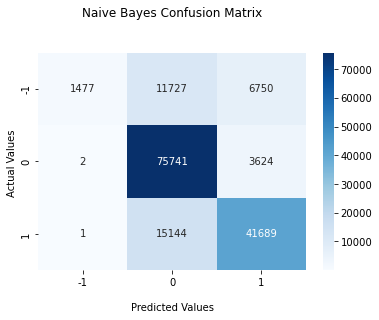

In [116]:

# labels = np.asarray(labels).reshape(3,3)


ax = sns.heatmap(NB_cf_matrix, annot=NB_cf_matrix,  fmt='', cmap='Blues')

ax.set_title('Naive Bayes Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['-1','0','1'])
ax.yaxis.set_ticklabels(['-1','0','1'])

# Display the visualization of the Confusion Matrix.
plt.show()

In [117]:
train_x_svm=matrix_X[:8000]
train_y_svm=y[:8000]
svm_model = SVC(kernel='linear')
svm_model.fit(train_x_svm,train_y_svm)

SVC(kernel='linear')

In [118]:
pred_x_svm=matrix_X[8000:]
pred_y_svm=y[8000:]
pred_svm=svm_model.predict(pred_x_svm)

In [119]:
svm_cf_matrix = confusion_matrix(pred_y_svm,pred_svm)
# cf_matrix
print("SVM Matrix , accuracy and f1-score\n\n")
print("SVm confusion matrix : \n",svm_cf_matrix)

print(classification_report(pred_y_svm,pred))
print("Accuracy of Model : ",(accuracy_score(pred_y_svm,pred_svm)))

SVM Matrix , accuracy and f1-score


SVm confusion matrix : 
 [[12530  5935  1489]
 [  107 78837   423]
 [  831  7875 48128]]
              precision    recall  f1-score   support

          -1       1.00      0.07      0.14     19954
           0       0.74      0.95      0.83     79367
           1       0.80      0.73      0.77     56834

    accuracy                           0.76    156155
   macro avg       0.85      0.59      0.58    156155
weighted avg       0.79      0.76      0.72    156155

Accuracy of Model :  0.8933111331689667


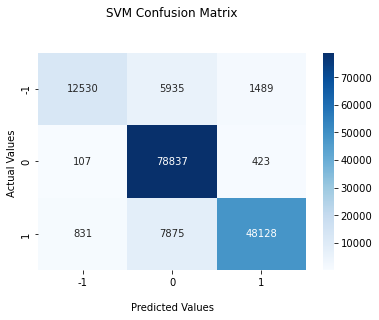

In [120]:
# labels = np.asarray(labels).reshape(3,3)


ax = sns.heatmap(svm_cf_matrix, annot=svm_cf_matrix,  fmt='', cmap='Blues')

ax.set_title('SVM Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['-1','0','1'])
ax.yaxis.set_ticklabels(['-1','0','1'])

# Display the visualization of the Confusion Matrix.
plt.show()

In [121]:
models = [('NB',NB_model),('svm',svm_model)]
ensemble = VotingClassifier(estimators=models)
results=model_selection.cross_val_score(ensemble, matrix_X[:8000], y[:8000])
print("Ensembler Majority voting ",results.mean(),results)

Ensembler Majority voting  0.8242499999999999 [0.7825   0.830625 0.8175   0.83625  0.854375]
